In [ ]:
import subprocess
import sys

def install_packages():
    packages = [
        'pandas>=2.2.0',
        'numpy>=1.26.0',
        'scikit-learn>=1.4.0',
        'joblib>=1.3.2',
        'matplotlib>=3.8.0',
        'seaborn>=0.13.0'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        except:
            print(f"Package {package} already installed or installation failed")

# Uncomment the line below if you need to install packages
install_packages()

In [3]:
import pandas as pd
import numpy as np
import logging
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

✅ All imports successful!
Pandas version: 2.3.0
NumPy version: 2.3.1
Scikit-learn version: 1.7.0


In [4]:
def create_sample_data(n_samples=1000, random_state=42):
    """Create synthetic loan approval dataset"""
    logger.info(f"Creating sample loan approval dataset with {n_samples} samples")
    np.random.seed(random_state)
    
    data = {}
    
    # Age distribution (25-70 years)
    data['age'] = np.random.normal(35, 10, n_samples).clip(18, 80)
    
    # Income based on age (higher income with experience)
    age_factor = (data['age'] - 25) / 45  # Normalize age
    base_income = np.random.normal(50000, 15000, n_samples)
    data['income'] = (base_income + age_factor * 20000).clip(20000, 150000)
    
    # Loan amount (correlated with income)
    income_factor = data['income'] / 100000
    data['loan_amount'] = (np.random.normal(150000, 50000, n_samples) * 
                          (0.5 + income_factor * 0.5)).clip(50000, 500000)
    
    # Credit score (normal distribution)
    data['credit_score'] = np.random.normal(650, 100, n_samples).clip(300, 850)
    
    # Employment years (correlated with age)
    max_years = np.maximum(0, data['age'] - 22)  # Can't work before 22
    data['employment_years'] = np.random.uniform(0, 1, n_samples) * max_years
    
    # Debt-to-income ratio
    data['debt_to_income'] = np.random.beta(2, 5, n_samples) * 0.8  # Skewed towards lower values
    
    # Categorical features
    education_choices = ['High School', 'Associate', 'Bachelor', 'Master', 'PhD']
    education_probs = [0.3, 0.15, 0.35, 0.15, 0.05]
    data['education'] = np.random.choice(education_choices, n_samples, p=education_probs)
    
    marital_choices = ['Single', 'Married', 'Divorced', 'Widowed']
    marital_probs = [0.35, 0.50, 0.12, 0.03]
    data['marital_status'] = np.random.choice(marital_choices, n_samples, p=marital_probs)
    
    property_choices = ['House', 'Apartment', 'Condo', 'None']
    property_probs = [0.45, 0.25, 0.20, 0.10]
    data['property_type'] = np.random.choice(property_choices, n_samples, p=property_probs)
    
    # Generate loan approval based on realistic criteria
    approval_score = (
        (data['credit_score'] / 850) * 0.35 +
        (data['income'] / 200000) * 0.25 +
        (1 - data['debt_to_income']) * 0.20 +
        (data['employment_years'] / 20) * 0.10 +
        (data['age'] / 70) * 0.05 +
        np.random.random(n_samples) * 0.05  # Random factor
    )
    
    # Add education bonus
    education_bonus = {'High School': 0, 'Associate': 0.05, 'Bachelor': 0.10, 
                      'Master': 0.15, 'PhD': 0.20}
    for i, edu in enumerate(data['education']):
        approval_score[i] += education_bonus[edu]
    
    # Approve loans with score > 0.5
    data['loan_approved'] = (approval_score > 0.5).astype(int)
    
    df = pd.DataFrame(data)
    
    logger.info(f"Dataset created successfully")
    logger.info(f"Approval rate: {df['loan_approved'].mean():.2%}")
    logger.info(f"Mean income: ${df['income'].mean():,.0f}")
    logger.info(f"Mean credit score: {df['credit_score'].mean():.0f}")
    
    return df

# Create the dataset
df = create_sample_data(n_samples=1000)
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📋 Dataset Info:")
df.info()

2025-07-05 03:01:10,288 - INFO - Creating sample loan approval dataset with 1000 samples
2025-07-05 03:01:10,291 - INFO - Dataset created successfully
2025-07-05 03:01:10,293 - INFO - Approval rate: 94.70%
2025-07-05 03:01:10,293 - INFO - Mean income: $55,749
2025-07-05 03:01:10,294 - INFO - Mean credit score: 647



📊 Dataset Shape: (1000, 10)
📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   float64
 1   income            1000 non-null   float64
 2   loan_amount       1000 non-null   float64
 3   credit_score      1000 non-null   float64
 4   employment_years  1000 non-null   float64
 5   debt_to_income    1000 non-null   float64
 6   education         1000 non-null   object 
 7   marital_status    1000 non-null   object 
 8   property_type     1000 non-null   object 
 9   loan_approved     1000 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 78.3+ KB


In [6]:
print("🔍 First 5 rows of the dataset:")
display(df.head())

print("\n📈 Statistical Summary:")
display(df.describe())

🔍 First 5 rows of the dataset:


,age,income,loan_amount,credit_score,employment_years,debt_to_income,education,marital_status,property_type,loan_approved
0,39.967142,77642.394451,103246.724476,459.219244,8.714387,0.302536,Bachelor,Single,Condo,1
1,33.617357,67699.441683,119715.656164,563.961499,0.992157,0.478677,PhD,Single,Condo,1
2,41.476885,58217.515718,87319.458962,608.639447,18.940519,0.277309,High School,Married,House,1
3,50.230299,51509.414363,101967.293022,838.768766,14.623589,0.322534,Bachelor,Single,House,1
4,32.658466,63877.112483,50000.000000,705.655312,6.546283,0.422440,Associate,Divorced,Apartment,1



📈 Statistical Summary:


,age,income,loan_amount,credit_score,employment_years,debt_to_income,loan_approved
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.319986,55749.097216,117663.965760,647.412010,6.672478,0.234915,0.947000
std,9.520957,15122.229399,38757.591457,101.055054,6.292743,0.128895,0.224146
min,18.000000,20000.000000,50000.000000,357.055131,0.000000,0.005181,0.000000
25%,28.524097,46116.100094,90047.863133,576.257955,1.696531,0.134411,1.000000
50%,35.253006,55135.388459,115332.017295,650.018457,4.862116,0.217698,1.000000
75%,41.479439,66088.535288,143557.328819,716.694541,10.314082,0.321510,1.000000
max,73.527315,103540.686757,262811.646680,850.000000,38.863222,0.655786,1.000000


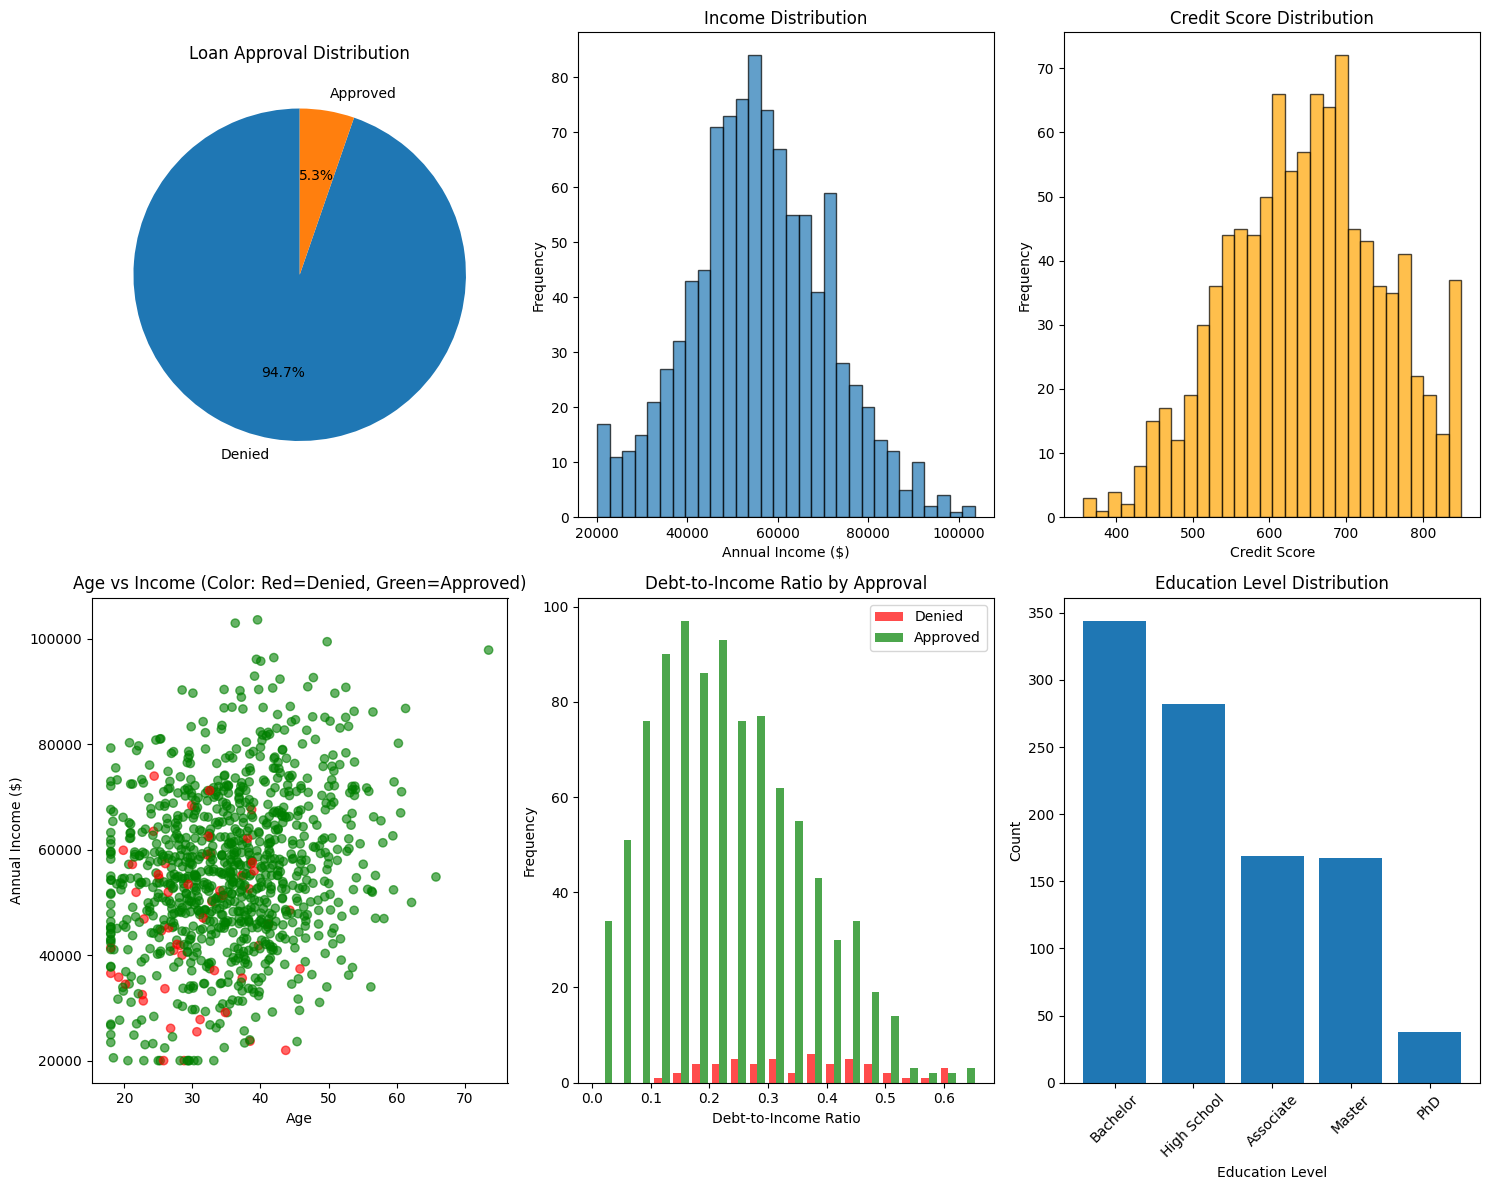


📊 Data Quality Check:
Missing values: 0
Duplicate rows: 0


In [11]:
plt.figure(figsize=(15, 12))

# 1. Loan approval distribution
plt.subplot(2, 3, 1)
approval_counts = df['loan_approved'].value_counts()
plt.pie(approval_counts.values, labels=['Denied', 'Approved'], autopct='%1.1f%%', startangle=90)
plt.title('Loan Approval Distribution')

# 2. Income distribution
plt.subplot(2, 3, 2)
plt.hist(df['income'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Annual Income ($)')
plt.ylabel('Frequency')

# 3. Credit score distribution
plt.subplot(2, 3, 3)
plt.hist(df['credit_score'], bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

# 4. Age vs Income scatter
plt.subplot(2, 3, 4)
colors = ['red' if x == 0 else 'green' for x in df['loan_approved']]
plt.scatter(df['age'], df['income'], c=colors, alpha=0.6)
plt.title('Age vs Income (Color: Red=Denied, Green=Approved)')
plt.xlabel('Age')
plt.ylabel('Annual Income ($)')

# 5. Debt-to-income ratio by approval
plt.subplot(2, 3, 5)
approved = df[df['loan_approved'] == 1]['debt_to_income']
denied = df[df['loan_approved'] == 0]['debt_to_income']
plt.hist([denied, approved], bins=20, alpha=0.7, label=['Denied', 'Approved'], color=['red', 'green'])
plt.title('Debt-to-Income Ratio by Approval')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.legend()

# 6. Education distribution
plt.subplot(2, 3, 6)
education_counts = df['education'].value_counts()
plt.bar(education_counts.index, education_counts.values)
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Data Quality Check:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")


In [12]:
class LoanDataPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        
    def preprocess_data(self, df):
        """Preprocess the loan data"""
        logger.info("Starting data preprocessing")
        
        df_processed = df.copy()
        
        # Encode categorical variables
        categorical_columns = ['education', 'marital_status', 'property_type']
        for col in categorical_columns:
            logger.info(f"Encoding categorical variable: {col}")
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
            df_processed[col] = self.label_encoders[col].fit_transform(df_processed[col])
        
        # Handle outliers using IQR method
        numerical_columns = ['age', 'income', 'loan_amount', 'credit_score', 'employment_years', 'debt_to_income']
        
        logger.info("Handling outliers using IQR method")
        for col in numerical_columns:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers before clipping
            outliers_count = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
            
            # Clip outliers
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)
            
            logger.info(f"Column {col}: {outliers_count} outliers handled")
        
        logger.info("Data preprocessing completed")
        return df_processed

# Initialize preprocessor and process data
preprocessor = LoanDataPreprocessor()
df_processed = preprocessor.preprocess_data(df)

print("\n✅ Data preprocessing completed!")
print(f"Processed dataset shape: {df_processed.shape}")
print(f"\nCategorical encoding mapping:")
for col, encoder in preprocessor.label_encoders.items():
    print(f"  {col}: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")

2025-07-05 03:08:38,949 - INFO - Starting data preprocessing
2025-07-05 03:08:38,949 - INFO - Encoding categorical variable: education
2025-07-05 03:08:38,951 - INFO - Encoding categorical variable: marital_status
2025-07-05 03:08:38,952 - INFO - Encoding categorical variable: property_type
2025-07-05 03:08:38,952 - INFO - Handling outliers using IQR method
2025-07-05 03:08:38,955 - INFO - Column age: 4 outliers handled
2025-07-05 03:08:38,956 - INFO - Column income: 6 outliers handled
2025-07-05 03:08:38,958 - INFO - Column loan_amount: 6 outliers handled
2025-07-05 03:08:38,959 - INFO - Column credit_score: 2 outliers handled
2025-07-05 03:08:38,960 - INFO - Column employment_years: 20 outliers handled
2025-07-05 03:08:38,961 - INFO - Column debt_to_income: 7 outliers handled
2025-07-05 03:08:38,962 - INFO - Data preprocessing completed



✅ Data preprocessing completed!
Processed dataset shape: (1000, 10)

Categorical encoding mapping:
  education: {'Associate': np.int64(0), 'Bachelor': np.int64(1), 'High School': np.int64(2), 'Master': np.int64(3), 'PhD': np.int64(4)}
  marital_status: {'Divorced': np.int64(0), 'Married': np.int64(1), 'Single': np.int64(2), 'Widowed': np.int64(3)}
  property_type: {'Apartment': np.int64(0), 'Condo': np.int64(1), 'House': np.int64(2), 'None': np.int64(3)}


In [13]:
class LoanApprovalModel:
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()
        
    def train_model(self, df_processed):
        """Train the loan approval model"""
        logger.info("Starting model training")
        
        # Prepare features and target
        X = df_processed.drop('loan_approved', axis=1)
        y = df_processed['loan_approved']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        logger.info(f"Training set size: {X_train.shape}")
        logger.info(f"Test set size: {X_test.shape}")
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train the model
        logger.info("Training Random Forest model...")
        self.model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        logger.info(f"Model training completed. Accuracy: {accuracy:.4f}")
        
        # Store feature names for later use
        self.feature_names = X.columns.tolist()
        
        return X_test, y_test, y_pred, y_pred_proba, accuracy

# Initialize and train model
model = LoanApprovalModel()
X_test, y_test, y_pred, y_pred_proba, accuracy = model.train_model(df_processed)

print(f"\n🎯 Model Training Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Test set size: {len(y_test)}")
print(f"Features used: {len(model.feature_names)}")

2025-07-05 03:10:17,675 - INFO - Starting model training
2025-07-05 03:10:17,680 - INFO - Training set size: (800, 9)
2025-07-05 03:10:17,682 - INFO - Test set size: (200, 9)
2025-07-05 03:10:17,687 - INFO - Training Random Forest model...
2025-07-05 03:10:17,785 - INFO - Model training completed. Accuracy: 0.9500



🎯 Model Training Results:
Accuracy: 0.9500
Test set size: 200
Features used: 9


📊 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.95      0.99      0.97       189

    accuracy                           0.95       200
   macro avg       0.81      0.59      0.63       200
weighted avg       0.94      0.95      0.94       200


🔍 Confusion Matrix:
[[  2   9]
 [  1 188]]


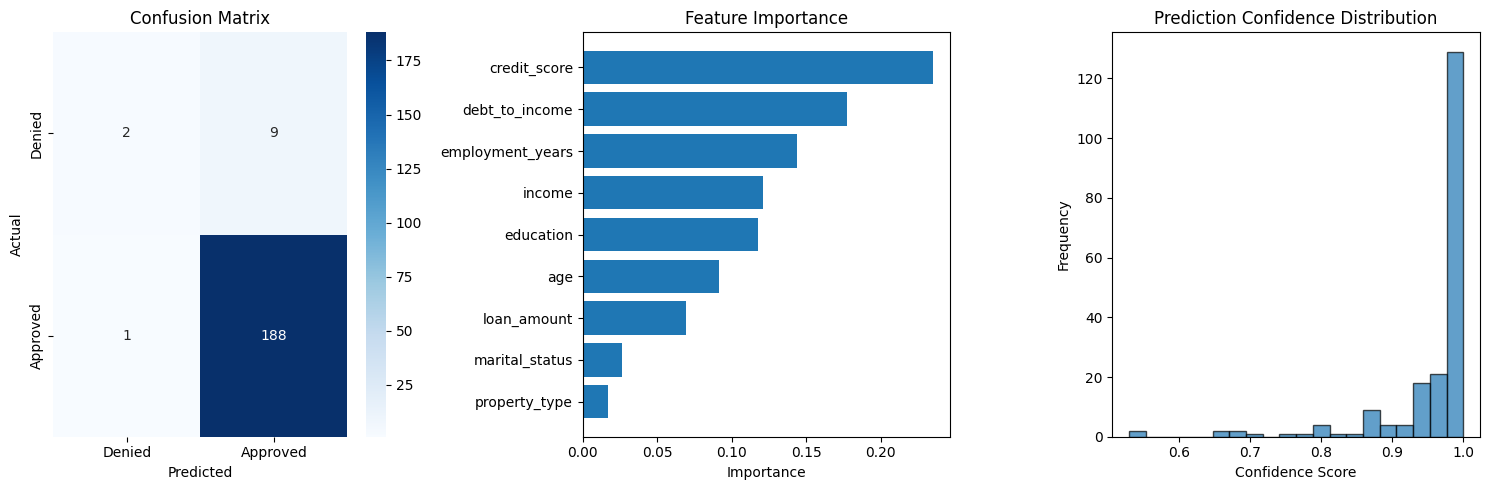


📈 Feature Importance Ranking:
  property_type       : 0.0168
  marital_status      : 0.0265
  loan_amount         : 0.0692
  age                 : 0.0912
  education           : 0.1178
  income              : 0.1213
  employment_years    : 0.1441
  debt_to_income      : 0.1778
  credit_score        : 0.2352


In [14]:
# Detailed evaluation
print("📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔍 Confusion Matrix:")
print(cm)

# Visualize results
plt.figure(figsize=(15, 5))

# 1. Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Denied', 'Approved'], 
           yticklabels=['Denied', 'Approved'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Feature Importance
plt.subplot(1, 3, 2)
feature_importance = pd.DataFrame({
    'feature': model.feature_names,
    'importance': model.model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')

# 3. Prediction Confidence Distribution
plt.subplot(1, 3, 3)
confidence_scores = np.max(y_pred_proba, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature importance ranking
print("\n📈 Feature Importance Ranking:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:20}: {row['importance']:.4f}")

In [15]:
def save_model_artifacts(model, preprocessor, model_dir="models"):
    """Save model and preprocessing artifacts"""
    logger.info("Saving model artifacts")
    
    # Create models directory
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model using pickle
    pkl_path = os.path.join(model_dir, "loan_model.pkl")
    with open(pkl_path, 'wb') as f:
        pickle.dump(model.model, f)
    logger.info(f"Model saved as pickle: {pkl_path}")
    
    # Save model using joblib
    joblib_path = os.path.join(model_dir, "loan_model.joblib")
    joblib.dump(model.model, joblib_path)
    logger.info(f"Model saved as joblib: {joblib_path}")
    
    # Save scaler
    scaler_path = os.path.join(model_dir, "scaler.pkl")
    with open(scaler_path, 'wb') as f:
        pickle.dump(model.scaler, f)
    logger.info(f"Scaler saved: {scaler_path}")
    
    # Save label encoders
    encoders_path = os.path.join(model_dir, "label_encoders.pkl")
    with open(encoders_path, 'wb') as f:
        pickle.dump(preprocessor.label_encoders, f)
    logger.info(f"Label encoders saved: {encoders_path}")
    
    # Save model metadata
    metadata = {
        'model_type': 'RandomForestClassifier',
        'feature_names': model.feature_names,
        'n_features': len(model.feature_names),
        'accuracy': float(accuracy),
        'training_timestamp': datetime.now().isoformat(),
        'label_encoders': {col: list(encoder.classes_) for col, encoder in preprocessor.label_encoders.items()}
    }
    
    metadata_path = os.path.join(model_dir, "model_metadata.json")
    import json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    logger.info(f"Model metadata saved: {metadata_path}")
    
    return {
        'pkl_path': pkl_path,
        'joblib_path': joblib_path,
        'scaler_path': scaler_path,
        'encoders_path': encoders_path,
        'metadata_path': metadata_path
    }

# Save all artifacts
saved_files = save_model_artifacts(model, preprocessor)

print("\n💾 Model Artifacts Saved:")
for description, path in saved_files.items():
    file_size = os.path.getsize(path) / 1024  # KB
    print(f"  {description:15}: {path} ({file_size:.1f} KB)")

2025-07-05 03:18:32,650 - INFO - Saving model artifacts
2025-07-05 03:18:32,653 - INFO - Model saved as pickle: models\loan_model.pkl
2025-07-05 03:18:32,671 - INFO - Model saved as joblib: models\loan_model.joblib
2025-07-05 03:18:32,673 - INFO - Scaler saved: models\scaler.pkl
2025-07-05 03:18:32,674 - INFO - Label encoders saved: models\label_encoders.pkl
2025-07-05 03:18:32,675 - INFO - Model metadata saved: models\model_metadata.json



💾 Model Artifacts Saved:
  pkl_path       : models\loan_model.pkl (546.2 KB)
  joblib_path    : models\loan_model.joblib (554.1 KB)
  scaler_path    : models\scaler.pkl (0.9 KB)
  encoders_path  : models\label_encoders.pkl (0.5 KB)
  metadata_path  : models\model_metadata.json (0.7 KB)


In [16]:
def load_and_test_models(saved_files):
    """Load and test both PKL and Joblib models"""
    logger.info("Testing model loading and prediction")
    
    # Load PKL model
    with open(saved_files['pkl_path'], 'rb') as f:
        pkl_model = pickle.load(f)
    
    # Load Joblib model
    joblib_model = joblib.load(saved_files['joblib_path'])
    
    # Load scaler
    with open(saved_files['scaler_path'], 'rb') as f:
        loaded_scaler = pickle.load(f)
    
    # Load label encoders
    with open(saved_files['encoders_path'], 'rb') as f:
        loaded_encoders = pickle.load(f)
    
    # Test with sample data
    sample_data = {
        'age': 35,
        'income': 65000,
        'loan_amount': 200000,
        'credit_score': 720,
        'employment_years': 5,
        'debt_to_income': 0.3,
        'education': 'Bachelor',
        'marital_status': 'Married',
        'property_type': 'House'
    }
    
    # Preprocess sample data
    sample_df = pd.DataFrame([sample_data])
    
    # Encode categorical variables
    for col, encoder in loaded_encoders.items():
        sample_df[col] = encoder.transform(sample_df[col])
    
    # Scale features
    sample_scaled = loaded_scaler.transform(sample_df)
    
    # Make predictions with both models
    pkl_prediction = pkl_model.predict(sample_scaled)[0]
    pkl_probability = pkl_model.predict_proba(sample_scaled)[0]
    
    joblib_prediction = joblib_model.predict(sample_scaled)[0]
    joblib_probability = joblib_model.predict_proba(sample_scaled)[0]
    
    print("\n🧪 Model Loading and Testing Results:")
    print(f"Sample applicant profile: {sample_data}")
    print(f"\nPKL Model:")
    print(f"  Prediction: {'Approved' if pkl_prediction == 1 else 'Denied'}")
    print(f"  Probability: {pkl_probability[1]:.3f}")
    
    print(f"\nJoblib Model:")
    print(f"  Prediction: {'Approved' if joblib_prediction == 1 else 'Denied'}")
    print(f"  Probability: {joblib_probability[1]:.3f}")
    
    # Verify both models give same results
    models_match = (pkl_prediction == joblib_prediction and 
                   np.allclose(pkl_probability, joblib_probability))
    
    print(f"\n✅ Models consistency check: {'PASSED' if models_match else 'FAILED'}")
    
    return pkl_model, joblib_model, loaded_scaler, loaded_encoders

# Test model loading
pkl_model, joblib_model, loaded_scaler, loaded_encoders = load_and_test_models(saved_files)

2025-07-05 03:20:40,342 - INFO - Testing model loading and prediction



🧪 Model Loading and Testing Results:
Sample applicant profile: {'age': 35, 'income': 65000, 'loan_amount': 200000, 'credit_score': 720, 'employment_years': 5, 'debt_to_income': 0.3, 'education': 'Bachelor', 'marital_status': 'Married', 'property_type': 'House'}

PKL Model:
  Prediction: Approved
  Probability: 1.000

Joblib Model:
  Prediction: Approved
  Probability: 1.000

✅ Models consistency check: PASSED
